In [ ]:
! pip install contractions

# Imports

In [ ]:
import pandas as pd
import numpy as np
import contractions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

# Setup

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
nltk.download('punkt') #required for tokenization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('averaged_perceptron_tagger') #required for lemmatization

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
nltk.download('wordnet') #required for lemmatization

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/NLP project/humor-detection/data/train.csv')
df_train

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
159995,Watch muhammad ali pull the greatest prank on ...,False
159996,Some days the problem is i care too much... to...,True
159997,If someone doesn't realize their blinker is st...,True
159998,I'm going out with a girl i met online who's a...,True


# Preprocess data

**1. Expand contractions**

In [ ]:
df_train.text = df_train.text.apply(lambda sequence: contractions.fix(sequence))
# contractions.fix("I hadn't done that")
df_train

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, I am not ...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its she will...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
159995,Watch muhammad ali pull the greatest prank on ...,False
159996,Some days the problem is i care too much... to...,True
159997,If someone does not realize their blinker is s...,True
159998,I am going out with a girl i met online who is...,True


**#TODO**: Explore if contractions expansions is a good pre processing idea. 
For example, in below example 'shell' becomes 'she will' making no sense of humor.

In [ ]:
contractions.fix('What do you call a turtle without its shell? dead.')

'What do you call a turtle without its she will? dead.'

**2. Lemmatization with nltk**

In [ ]:
tqdm.pandas() # https://stackoverflow.com/a/34365537/1317018 call tqdm.pandas() and call 'progress_xyz()' instead of any pandas methods `xyz()`  

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

df_train.text = df_train.text.progress_apply(lambda sequence: ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(sequence)]))

# ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize('I dont think you get what I am saying')])

df_train

  0%|          | 0/160000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

**#TODO** Analyze if lemmatization is good idea.
After analyzing different humors and their lemmatized versions, its seems so. 
But it was taking time to execute.

In [ ]:
pd.set_option('display.max_colwidth', None) # avoid pringing ... for long sequences
df_train.iloc[[30]].text

30    Ugh, i just spilled red wine all over the inside of my tummy.
Name: text, dtype: object

In [ ]:
' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(str(df_train.iloc[[30]].text))])

'30 Ugh , i just spill red wine all over the inside of my tummy . Name : text , dtype : object'

**3. Remove stopwords**

In [ ]:
stop_words = stopwords.words("english")
df_train.text = df_train.text.apply(lambda sequence: ' '.join([word for word in sequence.split(' ') if word not in stop_words]))
df_train.text


0             Joe biden rules 2020 bid: 'guys, i'm running'
1            Watch: darvish gave hitter whiplash slow pitch
2                     What call turtle without shell? dead.
3                    5 reasons 2016 election feels personal
4         Pasco police shot mexican migrant behind, new ...
                                ...                        
159995    Watch muhammad ali pull greatest prank unsuspe...
159996     Some days problem care much... today one days...
159997    If someone realize blinker still one minute ca...
159998    I'm going girl met online who's vegetarian... ...
159999    ‘people work system become desensitized brutal...
Name: text, Length: 160000, dtype: object

**#TODO**: Check whether stopwords removal is good preprocessing idea for humor detection. For example word "no" is in stopwords, but may have capability of making humor: "I would love to say yes, but my dog told me to say no."

In [ ]:
'no' in stop_words

True

**Save preprocessed data**


In [ ]:
# f = open('/content/drive/MyDrive/NLP project/humor-detection/data/train_contractions','wb') 
# pickle.dump(df_train, f)
# f.close()

# f = open('/content/drive/MyDrive/NLP project/humor-detection/data/train_contractions_lemmatization','wb') 
# pickle.dump(df_train, f)
# f.close()

**Load preprocessed data (only contractions applied)**

In [ ]:
f = open('/content/drive/MyDrive/NLP project/humor-detection/data/train_contractions_lemmatization','rb') 
df_train = pickle.load(f)
f.close()
df_train

,text,humor
0,"Joe biden rule out 2020 bid : 'guys , I be not...",False
1,Watch : darvish give hitter whiplash with slow...,False
2,What do you call a turtle without it she will ...,True
3,5 reason the 2016 election feel so personal,False
4,Pasco police shot mexican migrant from behind ...,False
...,...,...
159995,Watch muhammad ali pull the great prank on uns...,False
159996,Some day the problem be i care too much ... to...,True
159997,If someone do not realize their blinker be sti...,True
159998,I be go out with a girl i met online who be a ...,True


# CountVectorize data

Consider/explore these [interesting parameters](https://scikit-learn.org/stable/modules/generaated/sklearn.feature_extraction.text.CountVectorizer.html): `max_df`, `min_df`, `max_features`, `binary` (especially for multinomial naive bayes), `ngram_range`, `strip_accents`


In [ ]:
list(df_train.text)[:5]

["Joe biden rule out 2020 bid : 'guys , I be not run '",
 'Watch : darvish give hitter whiplash with slow pitch',
 'What do you call a turtle without it she will ? dead .',
 '5 reason the 2016 election feel so personal',
 'Pasco police shot mexican migrant from behind , new autopsy show']

In [ ]:
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(list(df_train.text)).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
cv

CountVectorizer(max_features=1500)

In [ ]:
Y = list(df_train.humor)
Y[:5]

[False, False, True, False, False]

# TfIDFVectorizer

In [ ]:
tfidf = TfidfVectorizer(max_features = 2500)
X_tfidf = tfidf.fit_transform(list(df_train.text)).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Multinomial Naive Bayes using CV
(On lammetized and contractions expanded data)

## Train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=1337)

In [ ]:
print('%s,%s,%s,%s'%(X_train.shape, X_test.shape, len(y_train), len(y_test)))

(144000, 2500),(16000, 2500),144000,16000


In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

## Test

In [ ]:
print('True humors in test set (7357+666) = ', sum(y_test))

True humors in test set (7357+666) =  8023


In [ ]:
y_pred = mnb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.87      0.89      7977
        True       0.88      0.92      0.90      8023

    accuracy                           0.89     16000
   macro avg       0.89      0.89      0.89     16000
weighted avg       0.89      0.89      0.89     16000



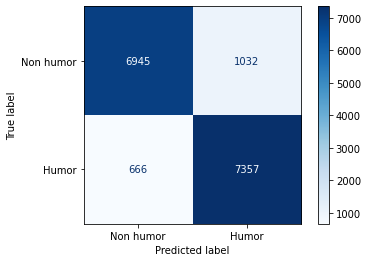

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non humor', 'Humor'])
disp.plot(cmap='Blues')
plt.show()

# Decision Tree using CV

## Train

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

**Save model**

In [ ]:
f = open('/content/drive/MyDrive/NLP project/humor-detection/models/decisiontree_contractions_lemmatization','wb') 
pickle.dump(dt, f)
f.close()

## Test

In [ ]:
y_pred = dt.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.86      0.86      7977
        True       0.86      0.87      0.86      8023

    accuracy                           0.86     16000
   macro avg       0.86      0.86      0.86     16000
weighted avg       0.86      0.86      0.86     16000



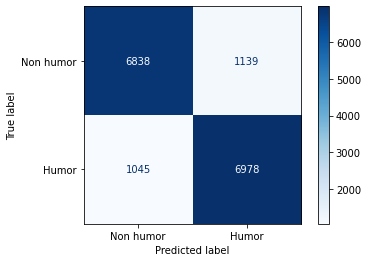

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non humor', 'Humor'])
disp.plot(cmap='Blues')
plt.show()

# SVM using TfIDF

## Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.1, random_state=1337)

In [ ]:
print('%s,%s,%s,%s'%(X_train.shape, X_test.shape, len(y_train), len(y_test)))

(144000, 2500),(16000, 2500),144000,16000


## Find C

In [ ]:
for i in range(1,9):
  C = i/10
  print('C=', C)
  svc = svm.SVC(C, verbose=True, kernel='linear', max_iter=10)
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  print(metrics.classification_report(y_test, y_pred))
  print('------------------------------------------------------')

## Train

In [ ]:
svc = svm.SVC(C = 0.75, verbose=True, kernel='linear', max_iter=8000)
svc.fit(X_train, y_train)

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=8000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(C=0.75, kernel='linear', max_iter=8000, verbose=True)

**Save model**

In [ ]:
f = open('/content/drive/MyDrive/CS626 NLP/humor-detection/models/svm_tfidf_contractions_lemmatization','wb') 
pickle.dump(svc, f)
f.close()

## Test

In [ ]:
y_pred = svc.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.80      0.84      7977
        True       0.82      0.88      0.85      8023

    accuracy                           0.84     16000
   macro avg       0.85      0.84      0.84     16000
weighted avg       0.85      0.84      0.84     16000



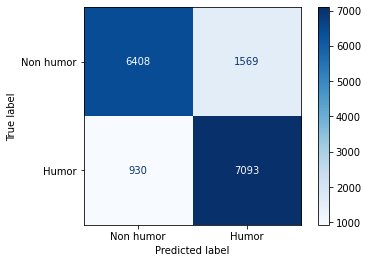

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non humor', 'Humor'])
disp.plot(cmap='Blues')
plt.show()